# flair NER

In [1]:
from flair.data import Sentence
from flair.models import SequenceTagger

# Load model multilingual NER
tagger = SequenceTagger.load("flair/ner-multi")

# Uji kalimat
sentence = Sentence("Anak yang sulung bernama Ahmad dan anak kedua bernama Muhammad.")
tagger.predict(sentence)

# Print hasil entitas
for entity in sentence.get_spans('ner'):
    print(entity.text, entity.get_label("ner").value)


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rayssa\.flair\models\ner-multi\models--flair--ner-multi. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to

2025-06-04 23:25:38,152 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, B-PER, E-PER, S-LOC, B-MISC, I-MISC, E-MISC, S-PER, B-ORG, E-ORG, S-ORG, I-ORG, B-LOC, E-LOC, S-MISC, I-PER, I-LOC, <START>, <STOP>
Ahmad PER
Muhammad PER


In [2]:
import pandas as pd
from flair.data import Sentence
from flair.models import SequenceTagger

# Load model flair NER
tagger = SequenceTagger.load("flair/ner-multi")

# Load cerita rakyat tokenized
df = pd.read_csv("cerita_rakyat_filtered.csv")

# Gabungkan token jadi kalimat per story_id + sentence_id
grouped = df.groupby(["story_id", "sentence_id"])["word"].apply(lambda x: " ".join(x)).reset_index()

results = []

for _, row in grouped.iterrows():
    story_id = row["story_id"]
    sentence_id = row["sentence_id"]
    text = row["word"]

    # Proses Flair NER
    sentence = Sentence(text)
    tagger.predict(sentence)

    # Ambil entitas dengan label PER (Person)
    entities = list(set([
        ent.text for ent in sentence.get_spans('ner')
        if ent.get_label('ner').value == "PER"
    ]))

    if entities:
        results.append({
            "story_id": story_id,
            "sentence_id": sentence_id,
            "characters": str(entities)
        })

# Simpan ke file
output_df = pd.DataFrame(results)
output_df.to_csv("hasil_ner_flair.csv", index=False)

print(f"✅ Flair selesai! Total kalimat dengan entitas PER: {len(output_df)}")


2025-06-04 23:26:56,806 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, B-PER, E-PER, S-LOC, B-MISC, I-MISC, E-MISC, S-PER, B-ORG, E-ORG, S-ORG, I-ORG, B-LOC, E-LOC, S-MISC, I-PER, I-LOC, <START>, <STOP>
✅ Flair selesai! Total kalimat dengan entitas PER: 1078


In [3]:
import pandas as pd
import ast
from sklearn.metrics import precision_score, recall_score, f1_score

# Load ground truth dan hasil flair
gt_df = pd.read_csv("labelled.csv")
pred_df = pd.read_csv("hasil_ner_flair.csv")
pred_df["characters"] = pred_df["characters"].apply(ast.literal_eval)

# === STEP 1: Ambil entitas PER dari ground truth ===
def extract_per_entities(group):
    entities = []
    current = []
    for word, label in zip(group["word"], group["TYPE"]):
        if label == "B-PER":
            if current:
                entities.append(" ".join(current))
            current = [word]
        elif label == "I-PER":
            current.append(word)
        else:
            if current:
                entities.append(" ".join(current))
                current = []
    if current:
        entities.append(" ".join(current))
    return list(set([e.lower() for e in entities]))

gt_entities_df = (
    gt_df.groupby(["story_id", "sentence_id"])
    .apply(extract_per_entities)
    .reset_index(name="true_entities")
)

# === STEP 2: Gabungkan prediksi dan ground truth ===
merged = pd.merge(pred_df, gt_entities_df, on=["story_id", "sentence_id"], how="outer").fillna("[]")
merged["characters"] = merged["characters"].apply(lambda x: x if isinstance(x, list) else ast.literal_eval(x))
merged["true_entities"] = merged["true_entities"].apply(lambda x: x if isinstance(x, list) else ast.literal_eval(x))

# === STEP 3: Evaluasi entity-level ===
y_true, y_pred = [], []

for _, row in merged.iterrows():
    pred_set = set([x.lower() for x in row["characters"]])
    true_set = set([x.lower() for x in row["true_entities"]])
    all_entities = pred_set.union(true_set)
    
    for ent in all_entities:
        y_true.append(int(ent in true_set))
        y_pred.append(int(ent in pred_set))

# === STEP 4: Print hasil ===
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"📊 Flair Evaluation")
print(f"🔎 Precision : {precision:.4f}")
print(f"🔎 Recall    : {recall:.4f}")
print(f"🔎 F1-score  : {f1:.4f}")


📊 Flair Evaluation
🔎 Precision : 0.0744
🔎 Recall    : 0.0676
🔎 F1-score  : 0.0709


C:\Users\rayssa\AppData\Local\Temp\ipykernel_30672\1628343986.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(extract_per_entities)


In [1]:
import pandas as pd
import ast
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# Load ground truth dan hasil flair
gt_df = pd.read_csv("labelled.csv")
pred_df = pd.read_csv("hasil_ner_flair.csv")
pred_df["characters"] = pred_df["characters"].apply(ast.literal_eval)

# === STEP 1: Ambil entitas PER dari ground truth ===
def extract_per_entities(group):
    entities = []
    current = []
    for word, label in zip(group["word"], group["TYPE"]):
        if label == "B-PER":
            if current:
                entities.append(" ".join(current))
            current = [word]
        elif label == "I-PER":
            current.append(word)
        else:
            if current:
                entities.append(" ".join(current))
                current = []
    if current:
        entities.append(" ".join(current))
    return list(set([e.lower() for e in entities]))

gt_entities_df = (
    gt_df.groupby(["story_id", "sentence_id"])
    .apply(extract_per_entities)
    .reset_index(name="true_entities")
)

# === STEP 2: Gabungkan prediksi dan ground truth ===
merged = pd.merge(pred_df, gt_entities_df, on=["story_id", "sentence_id"], how="outer").fillna("[]")
merged["characters"] = merged["characters"].apply(lambda x: x if isinstance(x, list) else ast.literal_eval(x))
merged["true_entities"] = merged["true_entities"].apply(lambda x: x if isinstance(x, list) else ast.literal_eval(x))

# === STEP 3: Evaluasi entity-level ===
y_true, y_pred = [], []

for _, row in merged.iterrows():
    pred_set = set([x.lower() for x in row["characters"]])
    true_set = set([x.lower() for x in row["true_entities"]])
    all_entities = pred_set.union(true_set)
    
    for ent in all_entities:
        y_true.append(int(ent in true_set))
        y_pred.append(int(ent in pred_set))

# === STEP 4: Hitung metrik ===
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

# === STEP 5: Print hasil ===
print(f"📊 Flair Evaluation")
print(f"🔎 Precision : {precision:.4f}")
print(f"🔎 Recall    : {recall:.4f}")
print(f"🎯 Accuracy  : {accuracy:.4f}")
print(f"🏅 F1-score  : {f1:.4f}")
print("\n🧩 Confusion Matrix:")
print(pd.DataFrame(cm, index=["Actual Negative (0)", "Actual Positive (1)"],
                       columns=["Predicted Negative (0)", "Predicted Positive (1)"]))


📊 Flair Evaluation
🔎 Precision : 0.0744
🔎 Recall    : 0.0676
🎯 Accuracy  : 0.0367
🏅 F1-score  : 0.0709

🧩 Confusion Matrix:
                     Predicted Negative (0)  Predicted Positive (1)
Actual Negative (0)                       0                    1293
Actual Positive (1)                    1434                     104


C:\Users\rayssa\AppData\Local\Temp\ipykernel_29032\239734859.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(extract_per_entities)


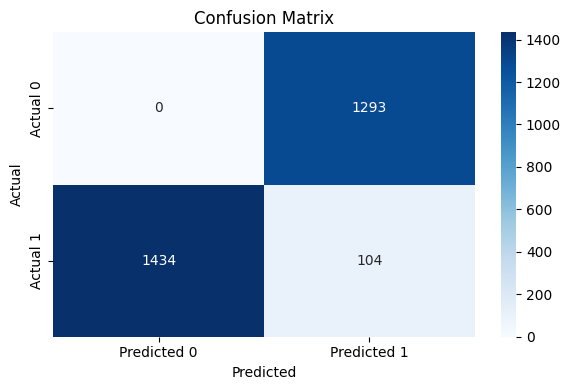

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# After calculating `y_true` and `y_pred`
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Plot & save to PNG
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()

# Save to your desired local path
plt.savefig("confusion_matrix_flair.png")  # or full path like "C:/Users/YourName/Documents/confusion_matrix_flair.png"
plt.show()  # Optional: display the plot


In [4]:
raw_data = """
Tador, cucu, anak semata wayangnya, anak
tetangga
kakek, suami
neneknya, nenek Tador, nenek
ayah, orang tua Tador, ayah Tador, Orang tuanya, Ayah, orang tuanya
ibu, orang tua Tador, ibu Tador, Ibu, Orang tuanya, ibunya, orang tuanya, Ibu Tador
warga, warga kampung
"""

# Step 1: Split semua baris jadi list token (jangan strip)
all_aliases = []

for line in raw_data.strip().split('\n'):
    items = line.split(',')  # Tanpa strip
    all_aliases.extend(items)

# Step 2: Buang duplikat, urutkan sesuai urutan muncul
seen = set()
unique_aliases = [x for x in all_aliases if not (x in seen or seen.add(x))]

# Step 3: Tampilkan hasil
print(unique_aliases)


['Tador', ' cucu', ' anak semata wayangnya', ' anak', 'tetangga', 'kakek', ' suami', 'neneknya', ' nenek Tador', ' nenek', 'ayah', ' orang tua Tador', ' ayah Tador', ' Orang tuanya', ' Ayah', ' orang tuanya', 'ibu', ' ibu Tador', ' Ibu', ' ibunya', ' Ibu Tador', 'warga', ' warga kampung']


## flair fine tuned

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os

# Load data
df = pd.read_csv("labelled.csv")

# Optional: convert label "0" to "O" (standard NER label)
df["TYPE"] = df["TYPE"].astype(str).replace("0", "O")

# Split by sentence
grouped = df.groupby(["story_id", "sentence_id"])

# Convert to list of sentences
sentences = []
for _, group in grouped:
    lines = [f"{row['word']} {row['TYPE']}" for _, row in group.iterrows()]
    sentences.append("\n".join(lines))

# Train/dev split
train_sent, dev_sent = train_test_split(sentences, test_size=0.2, random_state=42)

# Save to disk
os.makedirs("corpus", exist_ok=True)
with open("corpus/train.txt", "w", encoding="utf-8") as f:
    f.write("\n\n".join(train_sent))
with open("corpus/dev.txt", "w", encoding="utf-8") as f:
    f.write("\n\n".join(dev_sent))
with open("corpus/test.txt", "w", encoding="utf-8") as f:
    f.write("\n\n".join(dev_sent))  # reuse dev as test

print("✅ CoNLL files saved in folder `corpus/`")


✅ CoNLL files saved in folder `corpus/`


In [4]:
from collections import Counter

labels = []
with open("corpus/train.txt", encoding="utf-8") as f:
    for line in f:
        if line.strip():
            labels.append(line.strip().split()[-1])

print(Counter(labels))


Counter({'O': 16723, 'B-PER': 1476, 'I-PER': 679, 'i-PER': 2})


In [5]:
df["TYPE"] = df["TYPE"].astype(str).str.upper()  # make uppercase
df["TYPE"] = df["TYPE"].replace({
    "0": "O",
    "I-PER": "I-PER", # just to be safe
    "i-PER": "I-PER", # fix lowercase typo
})


In [7]:
from collections import Counter

labels = []
with open("corpus/train.txt", encoding="utf-8") as f:
    for line in f:
        if line.strip():
            labels.append(line.strip().split()[-1])

print(Counter(labels))


Counter({'O': 16723, 'B-PER': 1476, 'I-PER': 681})


In [8]:
from flair.data import Corpus
from flair.datasets import ColumnCorpus
from flair.embeddings import TransformerWordEmbeddings
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer

# Define column structure
columns = {0: "text", 1: "ner"}

# Load corpus from CoNLL files
corpus = ColumnCorpus("corpus", columns,
                      train_file="train.txt",
                      dev_file="dev.txt",
                      test_file="test.txt")

# Define tag dictionary
tag_type = "ner"
tag_dict = corpus.make_tag_dictionary(tag_type=tag_type)

# Use transformer embeddings (you can change to IndoBERT etc.)
embeddings = TransformerWordEmbeddings(
    model="indobenchmark/indobert-base-p1",
    fine_tune=True,
)

# Define tagger model
tagger = SequenceTagger(
    hidden_size=256,
    embeddings=embeddings,
    tag_dictionary=tag_dict,
    tag_type=tag_type,
    use_crf=True,
)

# Train model
trainer = ModelTrainer(tagger, corpus)
trainer.train(
    base_path="flair_ner_finetuned",  # or a new folder like flair_ner_clean
    learning_rate=1e-5,               # lower learning rate for stability
    mini_batch_size=8,
    max_epochs=10,
)


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-06-13 01:48:12,064 Reading data from corpus
2025-06-13 01:48:12,064 Train: corpus\train.txt
2025-06-13 01:48:12,065 Dev: corpus\dev.txt
2025-06-13 01:48:12,065 Test: corpus\test.txt


C:\Users\rayssa\AppData\Local\Temp\ipykernel_42624\1222683190.py:18: DeprecationWarning: Call to deprecated method make_tag_dictionary. (Use 'make_label_dictionary' instead.) -- Deprecated since version 0.8.
  tag_dict = corpus.make_tag_dictionary(tag_type=tag_type)


2025-06-13 01:48:14,947 SequenceTagger predicts: Dictionary with 3 tags: O, <START>, <STOP>
2025-06-13 01:48:14,977 ----------------------------------------------------------------------------------------------------
2025-06-13 01:48:14,979 Model: "SequenceTagger(
  (embeddings): TransformerWordEmbeddings(
    (model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(50001, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
  

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\flair\trainers\trainer.py:545: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp and flair.device.type != "cpu")


2025-06-13 01:48:16,802 epoch 1 - iter 11/116 - loss 0.00000006 - time (sec): 1.81 - samples/sec: 1233.51 - lr: 0.000010 - momentum: 0.000000
2025-06-13 01:48:17,786 epoch 1 - iter 22/116 - loss 0.00000004 - time (sec): 2.80 - samples/sec: 1348.09 - lr: 0.000010 - momentum: 0.000000
2025-06-13 01:48:19,118 epoch 1 - iter 33/116 - loss 0.00000002 - time (sec): 4.13 - samples/sec: 1380.58 - lr: 0.000010 - momentum: 0.000000
2025-06-13 01:48:20,288 epoch 1 - iter 44/116 - loss 0.00000003 - time (sec): 5.30 - samples/sec: 1402.10 - lr: 0.000010 - momentum: 0.000000
2025-06-13 01:48:21,175 epoch 1 - iter 55/116 - loss 0.00000003 - time (sec): 6.18 - samples/sec: 1430.89 - lr: 0.000010 - momentum: 0.000000
2025-06-13 01:48:22,129 epoch 1 - iter 66/116 - loss 0.00000001 - time (sec): 7.14 - samples/sec: 1486.32 - lr: 0.000010 - momentum: 0.000000
2025-06-13 01:48:23,384 epoch 1 - iter 77/116 - loss -0.00000000 - time (sec): 8.39 - samples/sec: 1498.38 - lr: 0.000010 - momentum: 0.000000
2025-

100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

2025-06-13 01:48:30,039 DEV : loss -2.4443394863737922e-08 - f1-score (micro avg)  0.0
2025-06-13 01:48:30,046  - 0 epochs without improvement
2025-06-13 01:48:30,047 ----------------------------------------------------------------------------------------------------
2025-06-13 01:48:30,048 learning rate too small - quitting training!
2025-06-13 01:48:30,049 ----------------------------------------------------------------------------------------------------
2025-06-13 01:48:30,050 Saving model ...


2025-06-13 01:48:30,514 Done.
2025-06-13 01:48:30,514 ----------------------------------------------------------------------------------------------------
2025-06-13 01:48:30,516 Testing using last state of model ...


100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

2025-06-13 01:48:32,685 
Results:
- F-score (micro) 0.0
- F-score (macro) 0.0
- Accuracy 0.0

By class:
              precision    recall  f1-score   support

         PER     0.0000    0.0000    0.0000     403.0

   micro avg     0.0000    0.0000    0.0000     403.0
   macro avg     0.0000    0.0000    0.0000     403.0
weighted avg     0.0000    0.0000    0.0000     403.0

2025-06-13 01:48:32,685 ----------------------------------------------------------------------------------------------------


{'test_score': 0.0}